# WeatherPy
----

### Observations:
* Temperature is the warmest near the equator, specifically between -20 and 20 degrees. The lowest temperatures have a latitude furthest from the equator (-60 to -40 and 60 to 80). 
* Latitude does not appear to have an impact on humidity, cloudiness, and wind speed.
* The higest correlation in the dataset is the correlation between latitude and maximum temperature. In the northern hemisphere, the correlation coefficient of -0.84 indicates a good negative relationship between latitude and max temperature.  The temperature is higher around the equator and as you move north away from the equator, the temperature goes down.  In the southern hemisphere, the correlation coefficient of 0.72 indicates a good relationship between latitude and max temperature - but it is not as high as the correlation in the northern hemisphere.  The temperature tends to be higher around the equator, but in the southern hemisphere there is some variability between -20 and -10 latitude where there are cities with higher temperatures than at the equator. 

In [67]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import requests
import json
from citipy import citipy
from pprint import pprint
import datetime

# API keys
from api_keys import weather_api_key

## Generate Cities List

In [68]:
#Randomly select at least 500 unique (non-repeat) cities based on latitude and longitude

#range of latitude and longitude - set latitude range = -90, 90. longitude range = -180,180, create list holding lat/long
#create a set of lat long combinations, use numpy np.random.uniform - generates the random list

# Set the number of cities to get data for
num_cities = 600

# Create a blank list to store cities and country codes
city_list = []
country_codes = []

# Get the nearest cities associated with the coordinates
for x in range(num_cities):
        lat = np.random.uniform(-90,90)
        lon = np.random.uniform(-180,180)
        city = citipy.nearest_city(lat, lon)
        
        #Check if the city exists in our list, if it does then get new coordinates and nearest city
        while city.city_name in city_list:
            lat = np.random.uniform(-90,90)
            lon = np.random.uniform(-180,180)
            city = citipy.nearest_city(lat, lon)
            
        #Append the city to the city list
        city_list.append(city.city_name)
        country_codes.append(city.country_code)

# Display number of cities in the list
#city_list
#len(city_list)

# Capitalize the country codes
country_codes = [x.upper() for x in country_codes]
#country_codes
    

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [69]:
# Save config information
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="
#print(query_url)

# set up lists to hold reponse info
latitude = []
longitude = []
max_temp = []
humidity = []
cloudiness = []
wind_speed = []
date = []

# setup row number and total number of rows
row_number = 1
num_cities = len(city_list)

# header for print log
print("Beginning Data Retrieval")
print("------------------------")

# Loop through the list of cities and perform a request for data on each
for cities in city_list:
    response = requests.get(query_url + cities).json()
    
    # If the city exists in citipy library, add data to the lists.  If not, then data weather data is null and move on to the next city.
    try:
        latitude.append(response["coord"]["lat"])
        longitude.append(response['coord']['lon'])
        max_temp.append(response['main']['temp_max'])
        humidity.append(response['main']['humidity'])
        cloudiness.append(response['clouds']['all'])
        wind_speed.append(response['wind']['speed'])
        date.append(response['dt'])
    except KeyError:
        latitude.append(np.nan)
        longitude.append(np.nan)
        max_temp.append(np.nan)
        humidity.append(np.nan)
        cloudiness.append(np.nan)
        wind_speed.append(np.nan)
        date.append(np.nan)

    print(f"Processing Record {row_number} of {num_cities} | {cities}")

    #pprint(response)
    
    row_number = row_number + 1

Beginning Data Retrieval
------------------------
Processing Record 1 of 600 | vaini
Processing Record 2 of 600 | debre tabor
Processing Record 3 of 600 | mys shmidta
Processing Record 4 of 600 | fukuma
Processing Record 5 of 600 | cape town
Processing Record 6 of 600 | rikitea
Processing Record 7 of 600 | iqaluit
Processing Record 8 of 600 | severo-kurilsk
Processing Record 9 of 600 | nuuk
Processing Record 10 of 600 | evensk
Processing Record 11 of 600 | kichera
Processing Record 12 of 600 | dikson
Processing Record 13 of 600 | djambala
Processing Record 14 of 600 | soure
Processing Record 15 of 600 | punta arenas
Processing Record 16 of 600 | wanaka
Processing Record 17 of 600 | deputatskiy
Processing Record 18 of 600 | belushya guba
Processing Record 19 of 600 | port blair
Processing Record 20 of 600 | butaritari
Processing Record 21 of 600 | busselton
Processing Record 22 of 600 | griffith
Processing Record 23 of 600 | wahran
Processing Record 24 of 600 | fort nelson
Processing Re

Processing Record 206 of 600 | georgetown
Processing Record 207 of 600 | qasigiannguit
Processing Record 208 of 600 | fez
Processing Record 209 of 600 | kichmengskiy gorodok
Processing Record 210 of 600 | castro
Processing Record 211 of 600 | yanam
Processing Record 212 of 600 | yibin
Processing Record 213 of 600 | vangaindrano
Processing Record 214 of 600 | conde
Processing Record 215 of 600 | zhanatas
Processing Record 216 of 600 | olafsvik
Processing Record 217 of 600 | cidreira
Processing Record 218 of 600 | mucurapo
Processing Record 219 of 600 | rawson
Processing Record 220 of 600 | talnakh
Processing Record 221 of 600 | burayevo
Processing Record 222 of 600 | kodiak
Processing Record 223 of 600 | te anau
Processing Record 224 of 600 | sabang
Processing Record 225 of 600 | airai
Processing Record 226 of 600 | bratsk
Processing Record 227 of 600 | maldonado
Processing Record 228 of 600 | pisco
Processing Record 229 of 600 | leningradskiy
Processing Record 230 of 600 | gigmoto
Proc

Processing Record 411 of 600 | escarcega
Processing Record 412 of 600 | kaspiyskiy
Processing Record 413 of 600 | synya
Processing Record 414 of 600 | ormara
Processing Record 415 of 600 | itarema
Processing Record 416 of 600 | pundaguitan
Processing Record 417 of 600 | christchurch
Processing Record 418 of 600 | selizharovo
Processing Record 419 of 600 | sahrak
Processing Record 420 of 600 | rocha
Processing Record 421 of 600 | west bay
Processing Record 422 of 600 | pathein
Processing Record 423 of 600 | ixtapa
Processing Record 424 of 600 | coahuayana
Processing Record 425 of 600 | velikovechnoye
Processing Record 426 of 600 | marathon
Processing Record 427 of 600 | pangai
Processing Record 428 of 600 | marienburg
Processing Record 429 of 600 | vila velha
Processing Record 430 of 600 | lac du bonnet
Processing Record 431 of 600 | qandala
Processing Record 432 of 600 | vrangel
Processing Record 433 of 600 | monatele
Processing Record 434 of 600 | pasighat
Processing Record 435 of 600

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [70]:
# Put all lists from the loop above into a dictionary
weather_dict = {
    "City": city_list,
    "Lat": latitude,
    "Lng": longitude,
    "Max Temp": max_temp,
    "Humidity": humidity,
    "Cloudiness": cloudiness,
    "Wind Speed": wind_speed,
    "Country": country_codes,
    "Date": date
}

# Create a dataframe from the dictionary 
weather_data = pd.DataFrame(weather_dict)

# Drop rows will null values
weather_data.dropna(inplace=True)

# Export dataframe to csv
weather_data.to_csv("city_data.csv", index=True, header=True)

#Display dataframe
weather_data.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,vaini,-21.20,-175.20,69.80,88.0,75.0,11.41,TO,1.600373e+09
1,debre tabor,11.85,38.02,52.92,85.0,30.0,3.51,ET,1.600373e+09
3,fukuma,33.77,130.47,71.60,94.0,75.0,5.82,JP,1.600373e+09
4,cape town,-33.93,18.42,57.00,93.0,37.0,5.82,ZA,1.600373e+09
5,rikitea,-23.12,-134.97,71.83,82.0,99.0,23.02,PF,1.600373e+09


In [71]:
# Generate statistical summary of the numerical  columns in the weather data dataframe
weather_data.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,5.480000e+02
mean,21.463449,19.867536,66.176843,69.879562,49.184307,8.446296,1.600373e+09
std,33.522835,89.230924,16.484304,21.745581,39.913123,5.744660,1.508920e+02
min,-54.800000,-179.170000,20.840000,1.000000,0.000000,0.340000,1.600373e+09
25%,-4.550000,-57.967500,51.800000,59.000000,1.000000,4.285000,1.600373e+09
50%,24.570000,26.175000,69.000000,75.000000,47.500000,7.185000,1.600373e+09
75%,50.120000,98.282500,79.480000,87.000000,90.000000,11.165000,1.600373e+09
max,78.220000,179.320000,104.340000,100.000000,100.000000,40.310000,1.600373e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [72]:
#Filter weather data to determine if there are cities with humidity over 100%
high_humidity = weather_data["Humidity"] > 100
high_humidity.value_counts()

False    548
Name: Humidity, dtype: int64

In [73]:
## Skipping the rest of this section because all cities in the data (at the time of submission) have 
## humidity less than or equal to 100%

#  Get the indices of cities that have humidity over 100%.


In [74]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

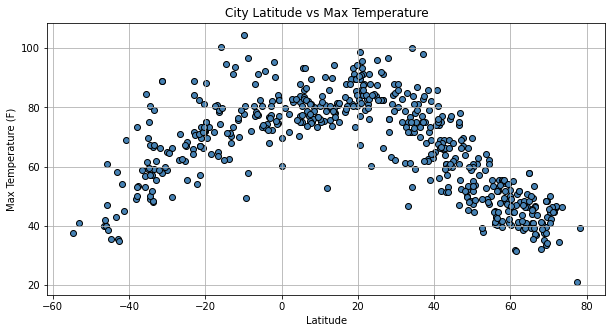

In [75]:
# Set the size of the plot (width, height) 
plt.figure(figsize=(10,5))

# Scatter Plot Format
plt.scatter(weather_data["Lat"], weather_data["Max Temp"], marker="o", facecolors="steelblue", edgecolors="black")
plt.title("City Latitude vs Max Temperature")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.grid()

# Save the plot image
output_path = os.path.join("Latitude_vs_Temperature.png")
plt.savefig(output_path)

# Show the plot
plt.show()

Latitude vs. Temperature Plot Observation:
* This code is analyzing the relationship between latitude and the maximum temperature.  In this scatter chart, you can see the plots are close toghether indicating there is a relationship between latitude and temperature.  For example, cities between -20 and 20 latitude tend to hover around 80 degrees max temperature.  The cities with the highest max temperatures are not at the equator exactly (0) but range from about -20 to 0 and 0 to ~25.  The lowest max temperatures have a latitude furthest from the equator (-60 to -40 and 60 to 80).

## Latitude vs. Humidity Plot

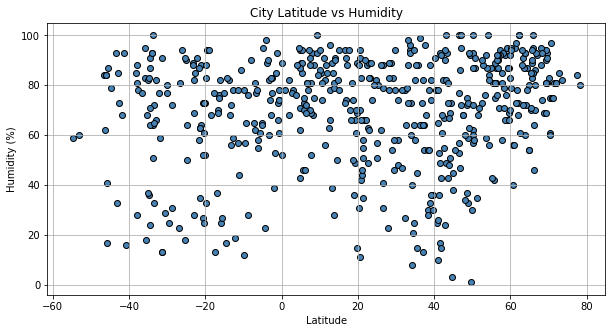

In [76]:
# Set the size of the plot (width, height) 
plt.figure(figsize=(10,5))

# Scatter Plot Format
plt.scatter(weather_data["Lat"], weather_data["Humidity"], marker="o", facecolors="steelblue", edgecolors="black")
plt.title("City Latitude vs Humidity")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid()

# Save the plot image
output_path = os.path.join("Latitude_vs_Humidity.png")
plt.savefig(output_path)

# Show the plot
plt.show()

Latitude vs. Humidity Plot Observation:
* This code is analyzing the relationship between latitude and the maximum temperature.  In this scatter chart, there does not appear to be a relationship between the latitude and humidity because the plots are quite dispersed.  For example, cities at the equator can have a humitidy anywhere from about 50% to 100%, which is similar to cities at latitide of 60 and 80.

## Latitude vs. Cloudiness Plot

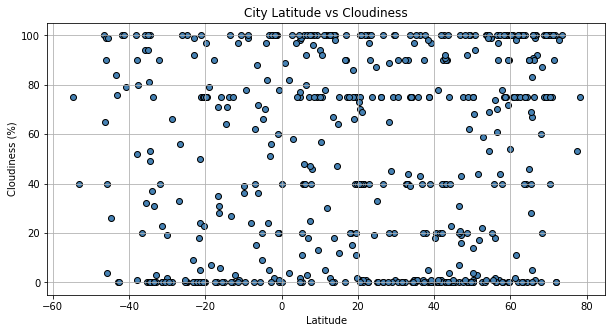

In [77]:
# Set the size of the plot (width, height) 
plt.figure(figsize=(10,5))

# Scatter Plot Format
plt.scatter(weather_data["Lat"], weather_data["Cloudiness"], marker="o", facecolors="steelblue", edgecolors="black")
plt.title("City Latitude vs Cloudiness")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.grid()

# Save the plot image
output_path = os.path.join("Latitude_vs_Cloudiness.png")
plt.savefig(output_path)

# Show the plot
plt.show()

City Latitude vs Cloudiness Observation:
* This code is analyzing the relationship between latitude and cloudiness.  In this scatter chart, there does not appear to be a relationship between the latitude and cloudiness because the plots are quite dispersed with many cities either at 0% cloudiness or 100% cloudiness regardless of the latitude location. 

## Latitude vs. Wind Speed Plot

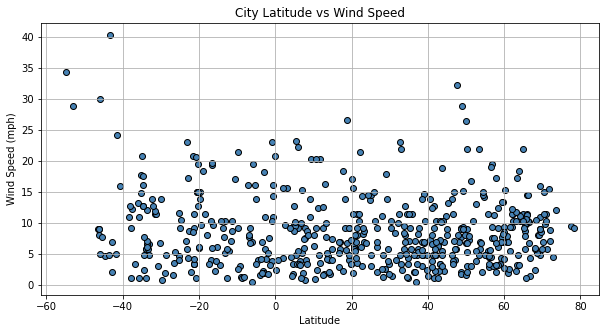

In [78]:
# Set the size of the plot (width, height) 
plt.figure(figsize=(10,5))

# Scatter Plot Format
plt.scatter(weather_data["Lat"], weather_data["Wind Speed"], marker="o", facecolors="steelblue", edgecolors="black")
plt.title("City Latitude vs Wind Speed")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.grid()

# Save the plot image
output_path = os.path.join("Latitude_vs_Wind.png")
plt.savefig(output_path)

#Show the plot
plt.show()

Latitude vs Wind Speed Observation:
* This code is analyzing the relationship between latitude and the wind speed.  In this scatter chart, there does not appear to be a relationship between the latitude and wind speed because the plots are quite dispersed.  In this diagram, you can see that most cities, regardless of latitude location have a wind speed of 0 to 10mph.


## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The correlation coefficient (r) is -0.84
The r-squared is: 0.7032271771710497
The p-value is 2.1553044001592555e-104


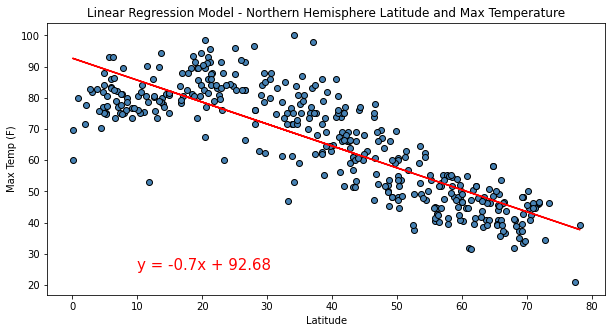

In [79]:
# Filter the dataframe to the northern hemisphere (0 to 90)
weather_data_nh = weather_data[(weather_data["Lat"] >= 0) & (weather_data['Lat'] <= 90)]

#Calculate Correlation
correlation = st.pearsonr(weather_data_nh["Lat"], weather_data_nh["Max Temp"])

x_values = weather_data_nh["Lat"]
y_values = weather_data_nh["Max Temp"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (10, 25), fontsize=15, color="red")
plt.title("Linear Regression Model - Northern Hemisphere Latitude and Max Temperature")
plt.xlabel("Latitude")
plt.ylabel("Max Temp (F)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("NH_Latitude_vs_Temperature.png")
plt.savefig(output_path)

plt.show()


Northern Hemisphere - Max Temp vs. Latitude Linear Regression Observation
* This code is analyzing the relationship between latitude and the maximum temperature in the northern hemisphere.  The correlation coefficient of -0.84 indicates a good negative relationship between latitude and max temperature.  The temperature is higher around the equator and as you move north away from the equator, the temperature goes down.  The slope of the line indicates that for every 10 degree change in latitude, the max temperature goes down by .7 degrees.

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The correlation coefficient (r) is 0.72
The r-squared is: 0.5122456746089422
The p-value is 4.23692921058796e-26


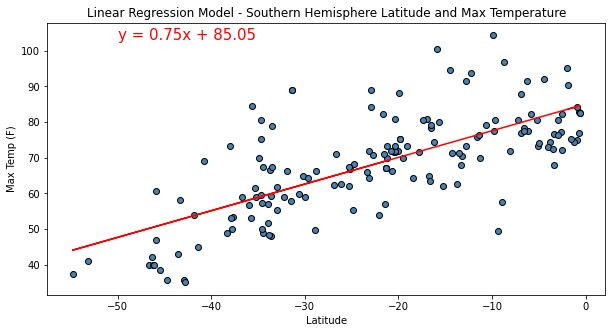

In [80]:
# Filter the dataframe to the southern hemisphere (0 to -90)
weather_data_sh = weather_data[(weather_data['Lat'] < 0)]

#Calculate Correlation
correlation = st.pearsonr(weather_data_sh["Lat"], weather_data_sh["Max Temp"])

x_values = weather_data_sh["Lat"]
y_values = weather_data_sh["Max Temp"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (-50, 103), fontsize=15, color="red")
plt.title("Linear Regression Model - Southern Hemisphere Latitude and Max Temperature")
plt.xlabel("Latitude")
plt.ylabel("Max Temp (F)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("SH_Latitude_vs_Temperature.png")
plt.savefig(output_path)

plt.show()

Southern Hemisphere - Max Temp vs. Latitude Linear Regression Observation
* This code is analyzing the relationship between latitude and the maximum temperature in the southern hemisphere.  The correlation coefficient of 0.72 indicates a good relationship between latitude and max temperature - but it is not as good of a relationship as the northern hemisphere (-0.84).  The temperature tends to be higher around the equator, but there is some variability between -20 and -10 latitude where there are cities with higher temperatures than at the equator. The slope of the line indicates that for every 10 degree change in latitude toward the equator, the max temperature goes up by .75 degrees.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The correlation coefficient (r) is 0.1
The r-squared is: 0.009353931214327727
The p-value is 0.056348899916084036


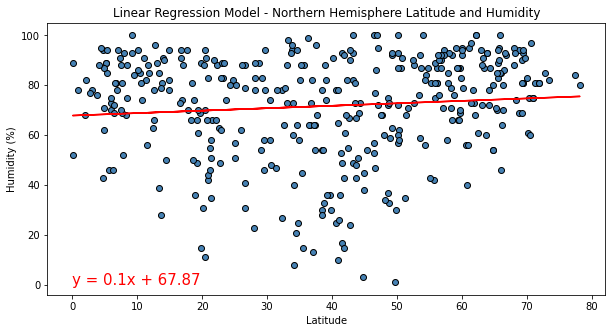

In [87]:
#Calculate Correlation
correlation = st.pearsonr(weather_data_nh["Lat"], weather_data_nh["Humidity"])

x_values = weather_data_nh["Lat"]
y_values = weather_data_nh["Humidity"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (0, 0), fontsize=15, color="red")
plt.title("Linear Regression Model - Northern Hemisphere Latitude and Humidity")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("NH_Latitude_vs_Humidity.png")
plt.savefig(output_path)

plt.show()

Northern Hemisphere - Latitude vs. Humidity Linear Regression Observation

* This code is analyzing the relationship between latitude and the humidity in the northern hemisphere. The correlation coefficient of 0.1 indicates there is not much of a relationship between latitude and humidity. From this chart, you can see that around the equator, the humidity is high.  Around 20-50 degrees latitude, the humidity is dispersed between 0 and 100%.  Around 60-80 degrees latitude, the humidity is higher between about 60% and 100%.  Based on this variability, the slope of the line if fairly flat at .1.

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The correlation coefficient (r) is 0.04
The r-squared is: 0.0016386570844671908
The p-value is 0.6135611938289717


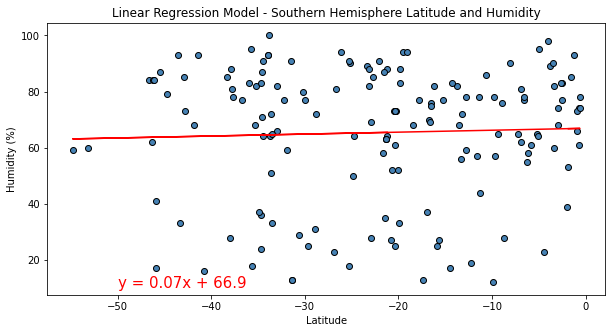

In [82]:
#Calculate Correlation
correlation = st.pearsonr(weather_data_sh["Lat"], weather_data_sh["Humidity"])

x_values = weather_data_sh["Lat"]
y_values = weather_data_sh["Humidity"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (-50, 10), fontsize=15, color="red")
plt.title("Linear Regression Model - Southern Hemisphere Latitude and Humidity")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("SH_Latitude_vs_Humidity.png")
plt.savefig(output_path)

plt.show()

Southern Hemisphere - Latitude vs. Humidity Linear Regression Observation

* This code is analyzing the relationship between latitude and the humidity in the southern hemisphere. The correlation coefficient of 0.04 indicates there is not a relationship between latitude and humidity. From this chart, you can see there is a lot of variability in humidity across each city latitude.

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The correlation coefficient (r) is 0.06
The r-squared is: 0.003470200835908447
The p-value is 0.24579571981800863


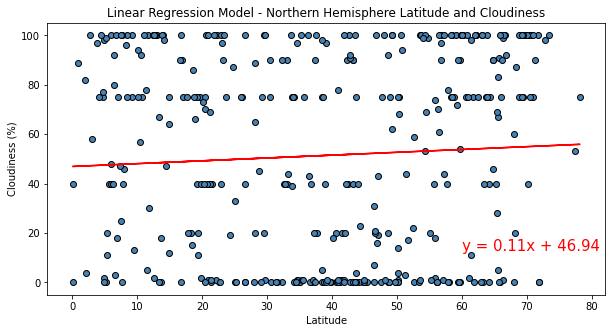

In [94]:
# Filter the dataframe to the northern hemisphere (0 to 90)
weather_data_nh = weather_data[(weather_data["Lat"] >= 0) & (weather_data['Lat'] <= 90)]

#Calculate Correlation
correlation = st.pearsonr(weather_data_nh["Lat"], weather_data_nh["Cloudiness"])

x_values = weather_data_nh["Lat"]
y_values = weather_data_nh["Cloudiness"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (60, 13), fontsize=15, color="red")
plt.title("Linear Regression Model - Northern Hemisphere Latitude and Cloudiness")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("NH_Latitude_vs_Cloudiness.png")
plt.savefig(output_path)

plt.show()

Northern Hemisphere - Latitude vs. Cloudiness Linear Regression Observation

* This code is analyzing the relationship between latitude and cloudinessin the northern hemisphere. The correlation coefficient of 0.06 indicates there is not much of a relationship between latitude and cloudiness. From this chart, you can see that across the northern hemisphere there is a high degree in cloudiness variability. Based on this variability, the slope of the line if fairly flat at .11 - as you move away from the equator, the cloudiness percentage only goes up by .11 for every 10 degrees of latitude.

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The correlation coefficient (r) is -0.02
The r-squared is: 0.00023633469652520586
The p-value is 0.8479655787304458


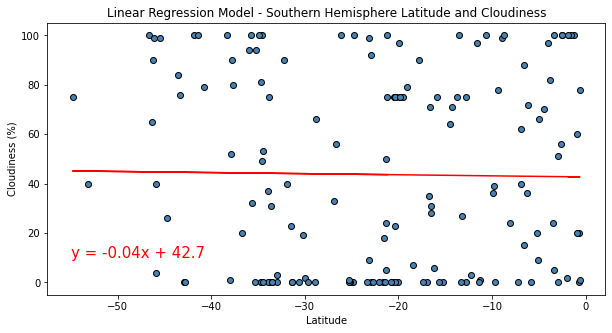

In [95]:
#Calculate Correlation
correlation = st.pearsonr(weather_data_sh["Lat"], weather_data_sh["Cloudiness"])

x_values = weather_data_sh["Lat"]
y_values = weather_data_sh["Cloudiness"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (-55, 10), fontsize=15, color="red")
plt.title("Linear Regression Model - Southern Hemisphere Latitude and Cloudiness")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("SH_Latitude_vs_Cloudiness.png")
plt.savefig(output_path)

plt.show()

Southern Hemisphere - Latitude vs. Humidity Linear Regression Observation

* This code is analyzing the relationship between latitude and the cloudiness in the southern hemisphere. The correlation coefficient of 0.02 indicates there is not much of a relationship between latitude and cloudiness. From this chart, you can see that the amount of cloudiness is widely dispersed between -40 and 0 degrees latitude.

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The correlation coefficient (r) is 0.06
The r-squared is: 0.003558297522997305
The p-value is 0.2398796697009958


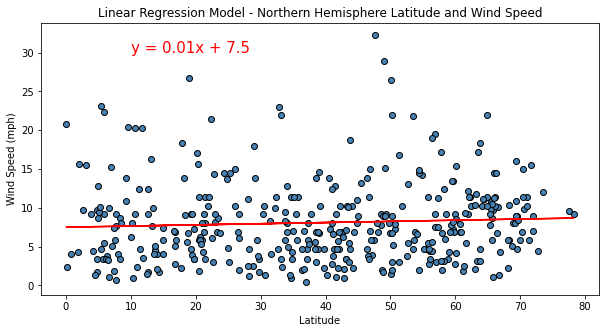

In [96]:
#Calculate Correlation
correlation = st.pearsonr(weather_data_nh["Lat"], weather_data_nh["Wind Speed"])

x_values = weather_data_nh["Lat"]
y_values = weather_data_nh["Wind Speed"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (10, 30), fontsize=15, color="red")
plt.title("Linear Regression Model - Northern Hemisphere Latitude and Wind Speed")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("NH_Latitude_vs_Wind.png")
plt.savefig(output_path)

plt.show()

Northern Hemisphere - Latitude vs. Wind Speed Linear Regression Observation

* This code is analyzing the relationship between latitude and the wind speed in the northern hemisphere. The correlation coefficient of 0.06 indicates there is not much of a relationship between latitude and wind speed. From this chart, you can see that most cities have windspeeds less than 10 mph.  The latitude does not have an impact on wind speed.  Based on this variability, the slope of the line if fairly flat at .01.

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The correlation coefficient (r) is -0.21
The r-squared is: 0.046079783888091114
The p-value is 0.0067591552014355984


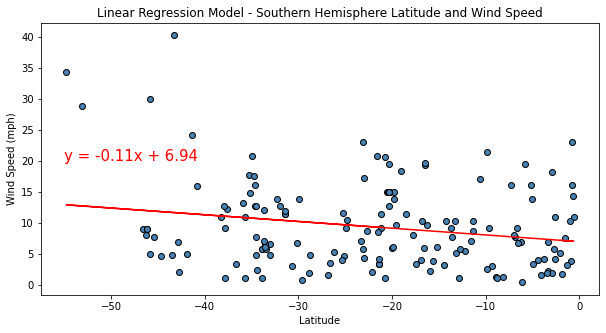

In [98]:
#Calculate Correlation
correlation = st.pearsonr(weather_data_sh["Lat"], weather_data_sh["Wind Speed"])

x_values = weather_data_sh["Lat"]
y_values = weather_data_sh["Wind Speed"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (-55, 20), fontsize=15, color="red")
plt.title("Linear Regression Model - Southern Hemisphere Latitude and Wind Speed")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("SH_Latitude_vs_Wind.png")
plt.savefig(output_path)

plt.show()

Southern Hemisphere - Latitude vs. Wind Speed Linear Regression Observation

* This code is analyzing the relationship between latitude and the wind speed in the southern hemisphere. The correlation coefficient of -0.21 indicates there is not much of a relationship between latitude and wind speed. From this chart, you can see that most cities have windspeeds less than about 10 mph. The latitude does not have much of an impact on wind speed. The slope of the line is -0.11, indicating that as you move 10 degrees closer to the equator that the wind speed goes down by -0.11 mph.